In [2]:
import pandas
import scipy.stats as stats
import networkx
import seaborn
import matplotlib
import matplotlib.pyplot as plt
import pyreadstat

In [3]:
df_original, meta_original = pyreadstat.read_sav("data-covid-source.sav")
print(f"There're {len(df_original.columns)} variables in the data:")
pandas.set_option('display.max_columns', None)
# pandas.set_option("display.max_rows", None)
pandas.set_option("display.precision", 1)
display(df_original.describe(percentiles=[]).transpose())
pandas.reset_option("max_columns")
# pandas.reset_option("max_rows")
pandas.reset_option("precision")

There're 510 variables in the data:


,count,mean,std,min,50%,max
Id,547.0,400.4,234.9,1.0,389.0,832.0
ATT_1_1,547.0,3.0,0.0,3.0,3.0,3.0
ATT_1_2,547.0,6.0,0.0,6.0,6.0,6.0
TIME_1,547.0,2026.2,3907.8,221.0,1274.0,55552.0
TIME_2,547.0,2363.2,5401.8,264.0,1408.0,88447.0
...,...,...,...,...,...,...
Wiedza_koronavir_t5,547.0,-0.3,0.2,-0.6,-0.3,0.2
WHO_FIZ_t4,547.0,5.9,1.7,1.0,6.0,9.0
WHO_SPOL_t4,547.0,6.2,1.7,1.0,6.5,9.0
BOGARDUS_uchodz_t4,547.0,2.7,1.1,1.0,2.6,5.0


In the above table there's some basic information on 510 variables measuring various psychological metrics from a longitude study of 547 people.<br>
There were 5 measurements, each one week apart from the others.<br>
The variables encode the number of measurement in their name by appending "\_t2", \_t3", ... to their name. For the first measurement "\_t1" is sometimes appended, sometimes not, depending on the variable.<br>
For some variables, not all 5 measurements are present - for example for communal narcissm ("cni" in the source data) the measurements are from week 1 and week 5 only. In the "cni" example, there are 16 variables from "cni1" to "cni16" describing various 16 metrics of communal narcissm, and are followed up with "cni1_t5" to "cni16_t5" (where "\_t5" indicates the week no. 5 of measurement taken).

The goal of this excercise is to:<br>
1. perform paired sample t-test for following measurements;
1. compute [Cohen's d - effect size value](https://en.wikipedia.org/wiki/Effect_size#Cohen's_d);
1. plot Cohen's d change in time (with mean trajectories);
1. compute partial correlation networks and basic networks' metrics;
1. plot the networks (with only signifcant changes - uncorrected p>0.05);
1. plot correlogram for average absolute edge values between and within questionnaires;
1. plot basic graphs' metrics for particular measurements at different times to easily observe change (or lack of thereof);
1. compute and show in correlation matrix the Pearson's correlation of considered variables

Only selected variables are to be considered, and those are:
1. Knowledge ("wiedza");
1. Communal Narcissim ("cni");
1. Dissinfection ("odkazanie");
1. Stay-at-home ("siedz_w_domu");
1. Cleaning-hands ("mycie_rak");
1. Masks ("maseczki");
1. Threatened ("zagr_ja");
1. Dark Triad ("DT")
1. Series of WHO health metrics ("WHO_zdr", "WHO_sen", "WHO_samooc_ind", "WHO_zwiazki", "WHO_wsparcie");


In [4]:
desired_variable_names = ['cni', 'DT', 'wiedza', 'odkazanie', 'siedz_w_domu', 'mycie_rak', 'maseczki', 'zagr_ja', 'WHO']
variable_list = []

for column in df_original.columns:
    if any(d in column for d in desired_variable_names):
        variable_list.append(column)
variable_list.sort(reverse=True)

pandas.set_option('display.max_columns', None)
pandas.set_option("display.max_rows", None)
pandas.set_option("display.precision", 1)
display(df_original[variable_list].describe(percentiles=[]).transpose())
pandas.reset_option("max_columns")
pandas.reset_option("max_rows")
pandas.reset_option("precision")

,count,mean,std,min,50%,max
zagr_ja_t4,547.0,3.1,1.0,1.0,3.0,5.0
zagr_ja,547.0,3.4,1.0,1.0,3.0,5.0
wiedza9_t5,547.0,1.8,0.4,1.0,2.0,2.0
wiedza9,547.0,0.2,0.4,0.0,0.0,1.0
wiedza8_t5,547.0,1.9,0.3,1.0,2.0,2.0
wiedza8,547.0,0.1,0.4,0.0,0.0,1.0
wiedza7_t5,547.0,1.4,0.5,1.0,1.0,2.0
wiedza7,547.0,0.2,0.4,0.0,0.0,1.0
wiedza6_t5,547.0,1.6,0.5,1.0,2.0,2.0
wiedza6,547.0,0.4,0.5,0.0,0.0,1.0


Let's match variable names from first study with second (week 4 or week 5) study:

In [5]:
varaibles_time_pairs_dict = dict()
for variable_candidate in variable_list:
    for match_candidate in variable_list:
        if variable_candidate is not match_candidate:
            if variable_candidate in match_candidate:
                varaibles_time_pairs_dict[variable_candidate] = match_candidate

# Let me correct a few wrong matches manually:
varaibles_time_pairs_dict['siedz_w_domu'] = 'siedz_w_domu_t4'
varaibles_time_pairs_dict['maseczki'] = 'maseczki_t4'
varaibles_time_pairs_dict['cni1'] = 'cni1_t5' 
varaibles_time_pairs_dict['DT1'] = 'DT1_t5'
varaibles_time_pairs_dict['mycie_rak'] = 'mycie_rak_t4'
varaibles_time_pairs_dict['odkazanie'] = 'odkazanie_t4'


For each of paired weeks of measurement for given variable, let's calculate the paired sample t-test:

In [6]:
paired_tests_dict = dict()
var_pairs_null_hypo_dict = dict()
var_pairs_alter_hypo_dict = dict()

for var_week_1, var_week_2 in varaibles_time_pairs_dict.items():
    pre = df_original[var_week_1]
    post = df_original[var_week_2]
    paired_tests_dict[f"{var_week_1}-{var_week_2}"] = stats.ttest_rel(pre, post)

print("Variable pairs for which a test for the null hypothesis that two \n(related as mentioned above) samples have identical average values holds \n(null hypothesis is NOT rejected):\n")
for var_pair, result_obj in paired_tests_dict.items():
    if result_obj.pvalue >= 0.05:
        var_pairs_null_hypo_dict[var_pair] = result_obj
        print(f"{var_pair:33} - p-value: {result_obj.pvalue:.3f}")

print("\nVariable pairs for which a test for the null hypothesis that two \nsamples have identical average values fails \n(null hypothesis IS rejected):\n")
for var_pair, result_obj in paired_tests_dict.items():
    if result_obj.pvalue < 0.05:
        var_pairs_alter_hypo_dict[var_pair] = result_obj
        print(f"{var_pair:33} - p-value: {result_obj.pvalue:.3f}, statistic: {result_obj.statistic:.3f}")

Variable pairs for which a test for the null hypothesis that two 
(related as mentioned above) samples have identical average values holds 
(null hypothesis is NOT rejected):

cni9-cni9_t5                      - p-value: 0.721
cni8-cni8_t5                      - p-value: 0.118
cni7-cni7_t5                      - p-value: 0.422
cni5-cni5_t5                      - p-value: 1.000
cni4-cni4_t5                      - p-value: 0.162
cni3-cni3_t5                      - p-value: 0.075
cni16-cni16_t5                    - p-value: 0.485
cni14-cni14_t5                    - p-value: 1.000
cni11-cni11_t5                    - p-value: 0.754
WHO_zwiazki-WHO_zwiazki_t4        - p-value: 0.583
WHO_wsparcie-WHO_wsparcie_t4      - p-value: 0.734
WHO_sen-WHO_sen_t4                - p-value: 0.223
WHO_samooc_kol-WHO_samooc_kol_t4  - p-value: 0.071
WHO_samooc_ind-WHO_samooc_ind_t4  - p-value: 0.247
WHO_SPOL-WHO_SPOL_t4              - p-value: 0.566
NAR_DT-NAR_DT_t5                  - p-value: 0.833
DT8-DT8_

Let's calculate the Cohen's d value - the difference between two means divided by a standard deviation for the data.<br>
$d = \frac{\bar{x}_1 - \bar{x}_2}{s}$
, where s is [pooled variance](https://en.wikipedia.org/wiki/Pooled_variance):<br>
$s = \sqrt{\frac{(n_1 - 1)s^2_1 + (n_2 - 1)s^2_2}{n_1 + n_2 - 2}}$
<br>
and where $s^2 = \frac{1}{n  - 1}\sum_{i=1}^{n}(x_i - \bar{x})^2$<br>
A positive d indicates that the first mean is higher. In contrast, a negative d indicates that the second mean is higher. A lower Cohen's d indicates the necessity of larger sample sizes, and vice versa - [Wikipedia](https://en.wikipedia.org/wiki/Effect_size#Cohen's_d)

In [7]:
import statistics

d_value_per_pair_dict = dict()
s_sqr = lambda l, a: (1/(len(l) - 1)) * (sum(map(lambda x: (x - a) ** 2, l)))
effect_size = lambda x: "very small" if abs(x)<0.01 else "small" if abs(x)<0.2 else "medium" if abs(x)<0.5 else "large" if abs(x)<0.8 else "very large" if abs(x)<1.2 else "huge"

for var_week_1, var_week_2 in varaibles_time_pairs_dict.items():
    s_sqr_week_1 = s_sqr(df_original[var_week_1], statistics.mean(df_original[var_week_1]))
    s_sqr_week_2 = s_sqr(df_original[var_week_2], statistics.mean(df_original[var_week_2]))
    len_week_1 = len(df_original[var_week_1])
    len_week_2 = len(df_original[var_week_2])
    pooled_var_s = (((len_week_1 - 1) * s_sqr_week_1 + (len_week_2 - 1) * s_sqr_week_2) / (len_week_1 + len_week_2 - 2)) ** 0.5
    d_value_per_pair_dict[f"{var_week_1}-{var_week_2}"] = (statistics.mean(df_original[var_week_1]) - statistics.mean(df_original[var_week_2])) / pooled_var_s

for var_pair in var_pairs_alter_hypo_dict.keys():
    print(f"{var_pair:30}: {d_value_per_pair_dict[var_pair]:6.3f} ({effect_size(d_value_per_pair_dict[var_pair])})")

zagr_ja-zagr_ja_t4            :  0.355 (medium)
wiedza9-wiedza9_t5            : -4.007 (huge)
wiedza8-wiedza8_t5            : -4.975 (huge)
wiedza7-wiedza7_t5            : -2.777 (huge)
wiedza6-wiedza6_t5            : -2.320 (huge)
wiedza5-wiedza5_t5            : -5.666 (huge)
wiedza4-wiedza4_t5            : -4.378 (huge)
wiedza3-wiedza3_t5            : -4.238 (huge)
wiedza2-wiedza2_t5            : -0.624 (large)
wiedza1-wiedza1_t5            : -3.745 (huge)
siedz_w_domu-siedz_w_domu_t4  :  0.767 (large)
odkazanie-odkazanie_t4        :  0.228 (medium)
mycie_rak-mycie_rak_t4        :  0.404 (medium)
maseczki-maseczki_t4          : -0.317 (medium)
cni6-cni6_t5                  :  0.110 (small)
cni2-cni2_t5                  :  0.086 (small)
cni15-cni15_t5                :  0.102 (small)
cni13-cni13_t5                :  0.106 (small)
cni12-cni12_t5                :  0.100 (small)
cni10-cni10_t5                :  0.118 (small)
cni1-cni1_t5                  : -0.110 (small)
WHO_zdr-WHO_zdr_t

For graph plotting purpose, let me reshape the data more suitably (into one dataframe, organised by test participants instead of tests):

In [19]:
new_df_column_names = ['Id', 'test', 'before', 'after']
paired_plot_data_df = pandas.DataFrame(columns=new_df_column_names)
paired_plot_data_list = []

index = 0
for _, row in df_original.iterrows():
    for var_week_1, var_week_2 in varaibles_time_pairs_dict.items():
        index += 1
        new_row = {'Id': row['Id'],
                   'test': var_week_1,
                   'before': row[var_week_1],
                   'after': row[var_week_2]
                  }
        paired_plot_data_list.append(new_row)
paired_plot_data_df = pandas.DataFrame.from_records(paired_plot_data_list)
display(paired_plot_data_df.head())

,Id,test,before,after
0,7.0,zagr_ja,5.0,1.0
1,7.0,wiedza9,0.0,2.0
2,7.0,wiedza8,0.0,2.0
3,7.0,wiedza7,0.0,1.0
4,7.0,wiedza6,0.0,1.0


The next step is to plot Cohen's d change in time (with mean trajectories).
On high level, the changes we're interested in are:
1. knowledge ("wiedza") (9 questions - range from 0 to 2);
1. threat-self ("zagr_ja") (range from 1 to 5);
1. Hygiene behavior related questions:
    1. stay-at-home ("siedz_w_domu") (range from 1 to 4),
    1. dissinfection ("odkazanie") (range from 1 to 4),
    1. washing hands ("mycie_rak") (range from 1 to 4),
    1. Masks ("maseczki") (range from 1 to 4),
1. Communal Narcissim ("cni") (7 questions) (range from 1 to 7);
1. Dark Triad ("DT") (7 questions) (range from 1 to 5);
1. WHO-related ("WHO") (2 questions) (range from 1 to 9)

Aside from the measured variables, there're also some demographic variables:
1. age,
1. sex,
1. kohort,
1. education,
1. faith (numbered 1 to 11)

The input data is just a measured answer for particular questions in a survey at some two points in time. In case of knowledge-related variables the data are 0 or 1 for first measurement and 1 or 2 for the second measurement, so I can't plot this as-is since it won't be meaningful. Let me plot the changes in sum of answers for knowledge, communal narcissim and dark triad for sexes:

<AxesSubplot: title={'center': 'Dark Triad'}, xlabel='variable', ylabel='value'>

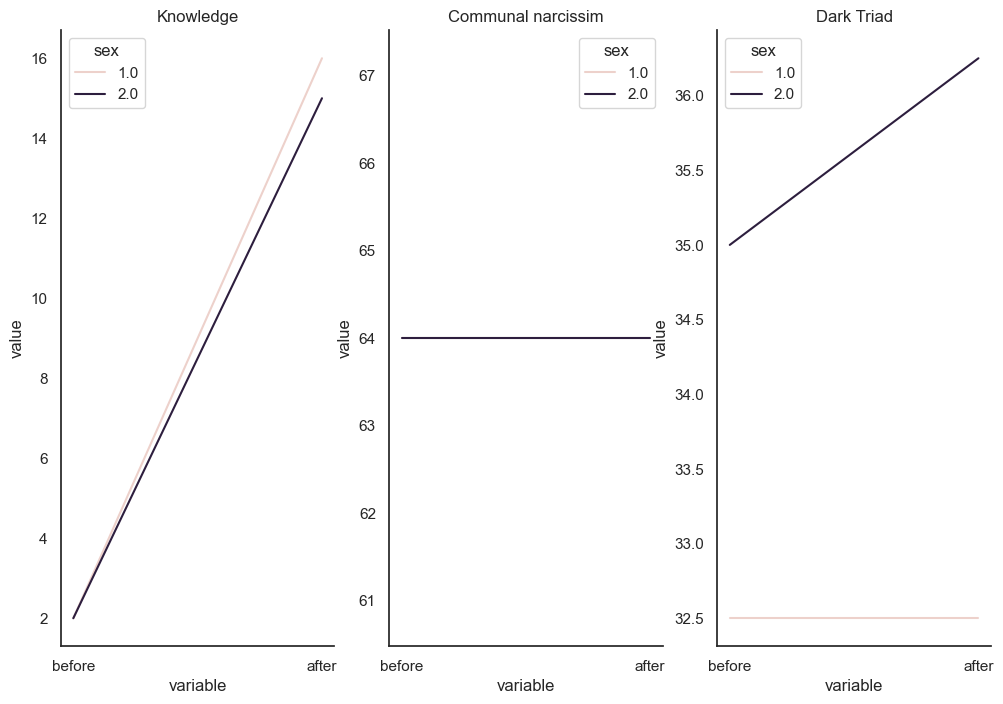

In [78]:
aggregated_knowledge_df = pandas.melt(paired_plot_data_df[paired_plot_data_df["test"].str.contains('wiedza')].groupby("Id")[["before", "after"]].sum(), value_vars=['before', 'after'], ignore_index=False).join(df_original[["Id", "sex", "age", "wyksztalcenie", "przynal_rel"]].set_index('Id'), on='Id', how='left', lsuffix='_caller', rsuffix='_other')
aggregated_narcissism_df = pandas.melt(paired_plot_data_df[paired_plot_data_df["test"].str.contains('cni')].groupby("Id")[["before", "after"]].sum(), value_vars=['before', 'after'], ignore_index=False).join(df_original[["Id", "sex", "age", "wyksztalcenie", "przynal_rel"]].set_index('Id'), on='Id', how='left', lsuffix='_caller', rsuffix='_other')
aggregated_darktriad_df = pandas.melt(paired_plot_data_df[paired_plot_data_df["test"].str.contains('DT')].groupby("Id")[["before", "after"]].sum(), value_vars=['before', 'after'], ignore_index=False).join(df_original[["Id", "sex", "age", "wyksztalcenie", "przynal_rel"]].set_index('Id'), on='Id', how='left', lsuffix='_caller', rsuffix='_other')

seaborn.set()
seaborn.set_theme(style="white")

fig, axes = plt.subplots(1, 3, figsize=(12, 8))
axes[0].set_title('Knowledge')
axes[1].set_title('Communal narcissim')
axes[2].set_title('Dark Triad')
seaborn.despine(fig)

seaborn.lineplot(ax=axes[0], data=aggregated_knowledge_df, x="variable", y="value", hue="sex", estimator="median", errorbar=None)
seaborn.lineplot(ax=axes[1], data=aggregated_narcissism_df, x="variable", y="value", hue="sex", estimator="median", errorbar=None)
seaborn.lineplot(ax=axes[2], data=aggregated_darktriad_df, x="variable", y="value", hue="sex", estimator="median", errorbar=None)